In [1]:
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import mglearn

### 3.5.2 凝聚聚类
凝聚聚类(agglomerative clustering)指的是许多基于相同原则构建的聚类算法，这一原则是：算法首先声明每个点是自己的簇，然后合并两个最相似的簇，直到满足某种停止准则为止。`scikit-learn`中实现的停止准则是簇的个数，因此相似的簇被合并，直到仅剩下指定个数的簇。还有一些链接(linkage)准则，规定如何度量“最相似的簇”。这种度量总是定义在两个现有的簇之间。

`scikit-learn`中实现了以下三种选项：
- ward：默认选项。ward挑选两个簇来合并，使得所有簇中的方差增加最小。这通常会得到大小差不多相等的簇
- average：average链接将簇中所有点之间平均距离最小的两个簇合并
- complete：complete链接(也称为最大链接)将簇中点之间最大距离最小的两个簇合并。

`ward`适用于大多数数据集，在我们的例子中将使用它。如果簇中的成员个数非常不同(比如其中一个比其他所有都大得多)，那么`average`或`complete`可能效果更好。

`图3-33`给出了在一个二维数据集上的凝聚聚类过程，要寻找三个簇。

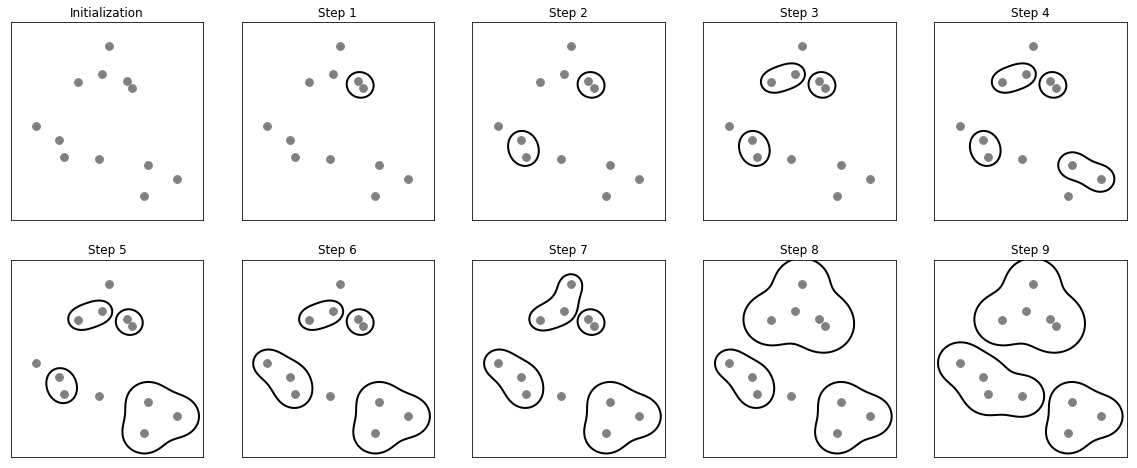

In [2]:
mglearn.plots.plot_agglomerative_algorithm()
plt.show()

开始每个点自成一簇。然后在每一个步骤中，相距最近的两个簇被合并。在前四个步骤中，选出两个单点簇并将其合并成两点簇。在`Step5`，其中一个两点簇被扩展到三个点；在`Step9`只剩下3个簇。由于我们指定寻找3个簇，因此算法结束。

我们来看一下凝聚聚类对我们这里使用的简单三簇数据的效果如何。由于算法的工作原理，凝聚算法不能对新数据点做出预测。因此`AgglomerativeClustering`没有`predict方法`。为了构造模型并得到训练集上簇的成员关系，可以改用`fit_predict`方法，结果如`图3-34`所示：

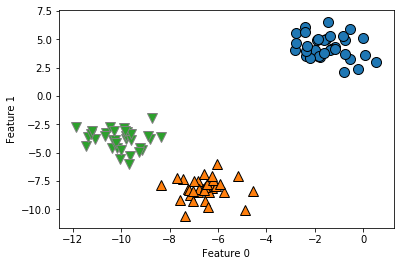

In [3]:
X, y = make_blobs(random_state=1)

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X)

mglearn.discrete_scatter(X[:, 0], X[:, 1], assignment)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

算法完美地完成了聚类。虽然凝聚聚类的`scikit-learn`实现需要你指定希望算法找到的簇的个数，但凝聚聚类方法为选择正确的个数提供了一些帮助，我们将在下面讨论。

#### 3.5.2.1 层次聚类与树状图
凝聚聚类生成了所谓的层次聚类(hierarchical clustering)。聚类过程迭代进行，每个点都从一个单点簇变为属于最终的某个簇。每个中间步骤都提供了数据的一种聚类(簇的个数也不相同)。有时候，同时查看所有可能的聚类是有帮助的。下一个例子(`图3-35`)叠加显示了`图3-33`中所有可能的聚类，有助于深入了解每个簇如何分解为较小的簇：

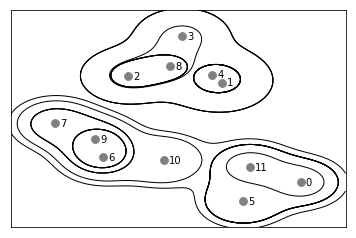

In [4]:
mglearn.plots.plot_agglomerative()
plt.show()

虽然这种可视化为层次聚类提供了非常详细的视图，但它依赖于数据的二维性质，因此不能用于具有两个以上特征的数据集。但还有另一个将层次聚类可视化的工具，叫作`树状图(dendrogram)`，它可以处理多维数据集。

目前`scikit-learn`没有绘制树状图的功能，但你可以利用`SciPy`轻松生成树状图。`SciPy`的聚类算法接口与`scikit-learn`的聚类算法稍有不同。`SciPy`提供了一个函数，接受数据数组$X$并计算出一个链接数组(linkage array)，它对层次聚类的相似度进行编码。然后我们可以将这个链接数组提供给`scipy`的`dendrogram函数`来绘制树状图(`图3-36`)。

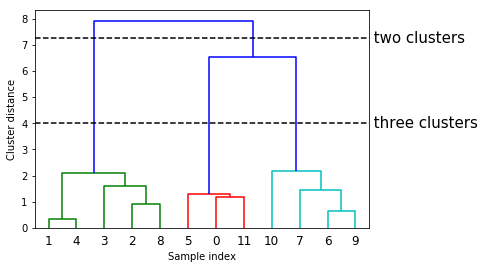

In [5]:
# 从SciPy中导入dendrogram函数和ward聚类函数
X, y = make_blobs(random_state=0, n_samples=12)

# 将ward聚类应用于数据数组X
# SciPy的ward函数返回一个数组，指定执行凝聚聚类时跨越的距离
linkage_array = ward(X)
# 现在为包含簇之间距离的linkage_array绘制树状图
dendrogram(linkage_array)

# 在树中标记划分成两个簇或三个簇的位置
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')

ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size': 15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()

树状图在底部显示数据点(编号从0到11)。然后以这些点(表示单点簇)作为叶节点绘制一棵树，每合并两个簇就添加一个新的父节点。

从下往上看，数据点1、4首先被合并；接下来，点6、9被合并为一个簇，以此类推。在顶层有两个分支，一个由点11、0、5、10、7、6、9组成，另一个由点1、4、3、2、8组成。这对应于图中左侧两个最大的簇。

树状图的$y$轴不仅说明凝聚算法中两个簇何时合并，每个分支的长度还表示被合并的簇之间的距离。在这张树状图中，最长的分支是用标记为“three clusters”的虚线表示的三条线。它们是最长的分支，这表示从三个簇到两个簇的过程中合并了一些距离非常远的点。我们在图像上方再次看到这一点，将剩下的两个簇合并为一个簇也需要跨越相对较大的距离。

凝聚聚类仍然无法分离像`two_moons数据集`这样复杂的形状。但我们要学习的下一个`DBSCAN算法`可以解决这个问题。